In [0]:
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision import datasets
import matplotlib.pyplot as plt
from IPython import display
from torch.autograd.variable import Variable
import time
from PIL import Image
import imageio
from torchsummary import summary

%matplotlib inline

In [0]:
device = 'cpu'
if torch.cuda.is_available():
  device = 'cuda'
print(device)   

cuda


In [0]:
class Generator(nn.Module):

  """
  the generator in a GAN
  """
  def __init__(self):
    super().__init__()

    n_features = 100
    n_out = 784
    self.hidden0 = nn.Sequential(
        nn.Linear(n_features,256),
        nn.LeakyReLU(0.2)
    )
    self.hidden1 = nn.Sequential(
        nn.Linear(256,512),
        nn.LeakyReLU(0.2)
    )
    self.hidden2 = nn.Sequential(
        nn.Linear(512,1024),
        nn.LeakyReLU(0.2)
    )
    self.out = nn.Sequential(
        nn.Linear(1024,n_out),
        nn.Tanh()
    )

  def forward(self,x):

    x = self.hidden0(x)
    x = self.hidden1(x)
    x = self.hidden2(x)
    x = self.out(x)
    return x

def noise(size):
  n = Variable(torch.randn(size, 100))
  return n.to(device)

In [0]:

class Discriminator(nn.Module):

  def __init__(self):

    super().__init__()
    n_features = 784
    n_out = 1

    self.hidden0 = nn.Sequential(
        nn.Linear(n_features,1024),
        nn.LeakyReLU(0.2),
        nn.Dropout(0.3)
    )
    self.hidden1 = nn.Sequential(
        nn.Linear(1024,512),
        nn.LeakyReLU(0.2),
        nn.Dropout(0.3)
    )
    self.hidden2 = nn.Sequential(
        nn.Linear(512,256),
        nn.LeakyReLU(0.2),
        nn.Dropout(0.3)
    )
    self.out = nn.Sequential(
        nn.Linear(256,n_out),
        nn.Sigmoid()
    )    
  def forward(self, x):
    x = x.view(-1,784)
    x = self.hidden0(x)
    x = self.hidden1(x)
    x = self.hidden2(x)
    x = self.out(x)
    return x


def images_to_vectors(images):
  return images.view(images.size(0), 784)

def vectors_to_images(vectors):
  return vectors.view(vectors.size(0), 1, 28, 28)      

In [0]:
discriminator = Discriminator()
generator = Generator()
discriminator.to(device)
generator.to(device)

Generator(
  (hidden0): Sequential(
    (0): Linear(in_features=100, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
  )
  (hidden1): Sequential(
    (0): Linear(in_features=256, out_features=512, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
  )
  (hidden2): Sequential(
    (0): Linear(in_features=512, out_features=1024, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
  )
  (out): Sequential(
    (0): Linear(in_features=1024, out_features=784, bias=True)
    (1): Tanh()
  )
)

In [0]:
summary(generator,(1,100))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 1, 256]          25,856
         LeakyReLU-2               [-1, 1, 256]               0
            Linear-3               [-1, 1, 512]         131,584
         LeakyReLU-4               [-1, 1, 512]               0
            Linear-5              [-1, 1, 1024]         525,312
         LeakyReLU-6              [-1, 1, 1024]               0
            Linear-7               [-1, 1, 784]         803,600
              Tanh-8               [-1, 1, 784]               0
Total params: 1,486,352
Trainable params: 1,486,352
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.04
Params size (MB): 5.67
Estimated Total Size (MB): 5.71
----------------------------------------------------------------


In [0]:
summary(discriminator,generator(noise(1)).shape)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [-1, 1024]         803,840
         LeakyReLU-2                 [-1, 1024]               0
           Dropout-3                 [-1, 1024]               0
            Linear-4                  [-1, 512]         524,800
         LeakyReLU-5                  [-1, 512]               0
           Dropout-6                  [-1, 512]               0
            Linear-7                  [-1, 256]         131,328
         LeakyReLU-8                  [-1, 256]               0
           Dropout-9                  [-1, 256]               0
           Linear-10                    [-1, 1]             257
          Sigmoid-11                    [-1, 1]               0
Total params: 1,460,225
Trainable params: 1,460,225
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forw

In [0]:
def real_data_target(size):
    '''
    Tensor containing ones, with shape = size
    '''
    data = Variable(torch.ones(size, 1))
    return data.to(device)

def fake_data_target(size):
    '''
    Tensor containing zeros, with shape = size
    '''
    data = Variable(torch.zeros(size, 1))
    return data.to(device)

In [0]:
batch_size = 100
compose = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((.5,), (.5,))
        ])
data = datasets.MNIST(root='./Data', train=True, transform=compose, download=True)
data_loader = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=True)

num_batches = len(data_loader)


Extracting ./Data/MNIST/raw/train-images-idx3-ubyte.gz to ./Data/MNIST/raw


Extracting ./Data/MNIST/raw/train-labels-idx1-ubyte.gz to ./Data/MNIST/raw



Extracting ./Data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./Data/MNIST/raw


Extracting ./Data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./Data/MNIST/raw
Processing...
Done!


/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


In [0]:
d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=0.0002)
g_optimizer = torch.optim.Adam(generator.parameters(), lr=0.0002)
g_losses = []
d_losses = []
images = []
criterion = nn.BCELoss()
d_steps = 1  
num_epochs = 200

In [0]:
def train_discriminator(optimizer,real_data,fake_data):

  optimizer.zero_grad()
  prediction_real = discriminator(real_data)
  loss_real = criterion(prediction_real,real_data_target(real_data.size(0)))
  loss_real.backward()

  prediction_fake = discriminator(fake_data)
  loss_fake = criterion(prediction_fake,fake_data_target(fake_data.size(0)))
  loss_fake.backward()

  optimizer.step()

  return loss_real+loss_fake
def train_generator(optimizer,fake_data):

  optimizer.zero_grad()
  prediction = discriminator(fake_data)
  error = criterion(prediction,real_data_target(prediction.size(0)))
  error.backward()
  optimizer.step()

  return error

In [0]:

test_noise = noise(64)

In [0]:
generator.train()
discriminator.train()

for epoch in range(num_epochs):
  
  start_time = time.time()
  g_error=0.0
  d_error=0.0
  for i,data in enumerate(data_loader):

    imgs,_ = data
    n = len(imgs)
    for j in range(d_steps):

      fake_data = generator(noise(n)).detach()
      real_data = imgs.to(device)
      d_error+=train_discriminator(d_optimizer, real_data, fake_data)
    fake_data = generator(noise(n))
    g_error+=train_generator(g_optimizer,fake_data)

  img = generator(test_noise).reshape(-1,1,28,28).cpu().detach()
  img_grid = torchvision.utils.make_grid(img)
  images.append(img_grid)
  g_losses.append(g_error/i) #mean error 
  d_losses.append(d_error/i) # mean error
  print(f'Epoch {epoch}: g_loss: {(g_error/i):.8f} d_loss: {(d_error/i):.8f} time:{time.time()-start_time} seconds')      


Epoch 0: g_loss: 2.91687942 d_loss: 0.93009096 time:19.544440746307373 seconds
Epoch 1: g_loss: 2.07811284 d_loss: 0.89270914 time:19.51482105255127 seconds
Epoch 2: g_loss: 2.65891933 d_loss: 0.57928854 time:19.343636751174927 seconds
Epoch 3: g_loss: 3.18902707 d_loss: 0.40044227 time:19.290306329727173 seconds
Epoch 4: g_loss: 2.91292787 d_loss: 0.50443447 time:19.31696343421936 seconds
Epoch 5: g_loss: 2.56522894 d_loss: 0.60115874 time:19.314801454544067 seconds
Epoch 6: g_loss: 2.88774848 d_loss: 0.49996656 time:19.300039768218994 seconds
Epoch 7: g_loss: 2.43171287 d_loss: 0.63164854 time:19.315078020095825 seconds
Epoch 8: g_loss: 2.30523181 d_loss: 0.66707361 time:19.357563972473145 seconds
Epoch 9: g_loss: 2.07609224 d_loss: 0.73720819 time:19.250924348831177 seconds
Epoch 10: g_loss: 2.20453191 d_loss: 0.71978813 time:19.30229139328003 seconds
Epoch 11: g_loss: 2.05114007 d_loss: 0.74485093 time:19.36535143852234 seconds
Epoch 12: g_loss: 2.01394749 d_loss: 0.74631757 time:1

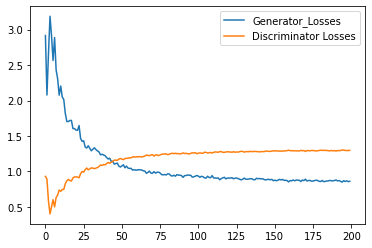

In [0]:
plt.plot(g_losses, label='Generator_Losses')
plt.plot(d_losses, label='Discriminator Losses')
plt.legend()

In [0]:
to_image = transforms.Compose([transforms.ToPILImage(),transforms.Resize((500,500))])

In [0]:
imgs = [np.array(to_image(i)) for i in images]
imageio.mimsave('progress.gif', imgs)

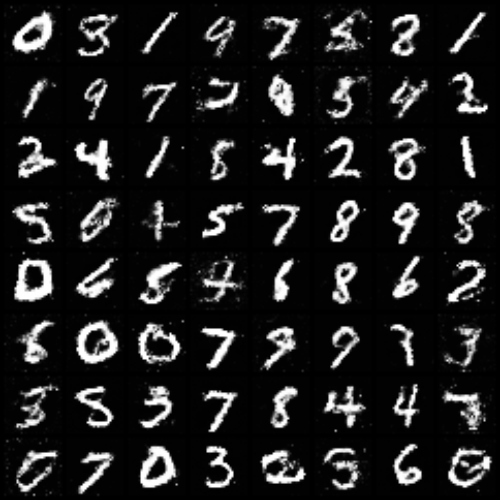

In [0]:
to_image(torchvision.utils.make_grid(generator(test_noise).reshape(-1,1,28,28).cpu().detach()))